In [ ]:
import re
import os
import json
import numpy as np
import pandas as pd
import torch
import random
import pickle
from torch.utils.data import Dataset, DataLoader

In [ ]:
ls

In [ ]:
files = sorted(os.listdir('RRUFF/raman'))

In [ ]:
# Opening JSON file
f = open('RRUFF/labels.json',)
   
# returns JSON object as 
# a dictionary
analytes = json.load(f)
   
# Iterating through the json
# list
for i in analytes:
    print(i)
  
# Closing file
f.close()

In [ ]:
print(files[0])
files[0].split('_')

In [ ]:
dataset_dict={}

In [ ]:
count = 0
dataset_dict = {}
for analyte in sorted(list(analytes.keys())):
  words = [analyte, 'Processed']
  # print(analyte)
  for _file_ in files:
    # print(_file_)
    stringlist = _file_.split('_')
    if words[0] in stringlist and words[1] in stringlist:
      print('analyte: {}, filename: {} \n'.format(analyte, _file_))
      if analyte not in dataset_dict:
        print('analyte not in dataset')
        print(analyte)
        # print(dataset_dict[analyte])
        dataset_dict[analyte] = [_file_]
      else:
        print('analyte in dataset')
        print(analyte)
        print(dataset_dict[analyte])
        dataset_dict[analyte].append(_file_)

In [ ]:
dataset_dict

In [ ]:
with open('dataset_dict.json', 'w') as fp:
    json.dump(dataset_dict, fp)

In [ ]:
# Opening JSON file
f = open('RRUFF/dataset_dict.json',)
   
# returns JSON object as 
# a dictionary
dataset_dict = json.load(f)
   
# Iterating through the json
# list
for i in dataset_dict:
    print(i)
  
# Closing file
f.close()

In [ ]:
print(len(list(dataset_dict.keys())))
print(len(list(analytes.keys())))

In [ ]:
labels = {}
for index, line in enumerate(files):
    mineral_name = re.findall('[^_]*', line)[0]
    if mineral_name in labels:
        labels[mineral_name][1] += 1
    else:
        labels[mineral_name] = [index, 0]

In [ ]:
with open('labels.json', 'w') as fp:
        json.dump(labels, fp,  indent=4)

In [ ]:
def peakdet(v, delta, x=None):
    """
    Converted from MATLAB script at http://billauer.co.il/peakdet.html

    Returns two arrays

    function [maxtab, mintab]=peakdet(v, delta, x)
    %PEAKDET Detect peaks in a vector
    %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
    %        maxima and minima ("peaks") in the vector V.
    %        MAXTAB and MINTAB consists of two columns. Column 1
    %        contains indices in V, and column 2 the found values.
    %      
    %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
    %        in MAXTAB and MINTAB are replaced with the corresponding
    %        X-values.
    %
    %        A point is considered a maximum peak if it has the maximal
    %        value, and was preceded (to the left) by a value lower by
    %        DELTA.

    % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
    % This function is released to the public domain; Any use is allowed.

    """
    maxtab = []
    mintab = []

    if x is None:
        x = np.arange(len(v))

    v = np.asarray(v)

    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')

    if not np.isscalar(delta):
        sys.exit('Input argument delta must be a scalar')

    if delta <= 0:
        sys.exit('Input argument delta must be positive')

    mn, mx = np.Inf, -np.Inf
    mnpos, mxpos = np.NaN, np.NaN

    lookformax = True

    for i in np.arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]

        if lookformax:
            if this < mx - delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn + delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return np.array(maxtab), np.array(mintab)

In [ ]:
dataset_list = []
for index, filename in enumerate(files):
    tmp = pd.read_csv('RRUFF/raman/' + filename, sep=',', comment='#', header=None)  
    dataset_list.append(np.array(tmp.iloc[:, 1], dtype=np.float64))
    if index % 100 == 0:
      print(index // 100)

In [ ]:
len(files)

In [ ]:
check = pd.read_csv('RRUFF/raman/' + files[random.randint(0, 36964)], sep=',', comment='#', header=None)
wavenumber = np.array(check.iloc[:, 0], dtype=np.float64)
spectra = np.array(check.iloc[:, 1], dtype=np.float64)
print(type(check.iloc[:, 1]))

In [ ]:
maxtab, mintab = peakdet(spectra / np.max(spectra), 0.08)

In [ ]:
# import matplotlib.pyplot as plt
# plt.figure(figsize=(15, 10))
# plt.plot(spectra)
# plt.scatter(np.array(maxtab)[:,0], np.array(maxtab)[:,1] * np.max(spectra), color='blue')
# # plt.scatter(np.array(mintab)[:,0], np.array(mintab)[:,1], color='red')
plt.savefig('nice_peak.png', dpi=600)

In [ ]:
print(wavenumber.shape)
print(spectra.shape)

In [ ]:
path = 'RRUFF/raman/'
analytes_peak_chosen_ones_dict = {}
count = 0
pos = []
for index, analyte in enumerate(list(dataset_dict.items())):
  if len(analyte[1]) > 20:
    count += 1
    pos.append(index)
    # # print(len(i[1]))
    # for filename in analyte[1]:
    #   tmp = pd.read_csv(path + filename, sep=',', comment='#', header=None)
    #   wavenumber = np.array(tmp.iloc[:, 0], dtype=np.float64)
    #   spectra = np.array(tmp.iloc[:, 1], dtype=np.float64)
    #   maxtab, mintab = peakdet(spectra / np.max(spectra), 0.07, wavenumber)
    #   if analyte[0] not in analytes_peak_chosen_ones_dict:
    #     print('analyte not in dataset')
    #     print(analyte)
    #     # print(dataset_dict[analyte])
    #     if maxtab.ndim > 1 and mintab.ndim > 1:
    #       analytes_peak_chosen_ones_dict[analyte[0]] = [(filename, maxtab)]
    #   else:
    #     print('analyte in dataset')
    #     print(analyte)
    #     if maxtab.ndim > 1 and mintab.ndim > 1:
    #       analytes_peak_chosen_ones_dict[analyte[0]].append((filename, maxtab))
print(count)

In [ ]:
print(list(dataset_dict.items()))

In [ ]:
import math
from scipy.signal import savgol_filter

In [ ]:
path = 'RRUFF/raman/'
analytes_peak_chosen_ones_dict = {}
for index, analyte in enumerate(list(dataset_dict.items())):
  if len(analyte[1]) > 20:
    # print(len(i[1]))
    snr = []
    for filename in analyte[1]:
      tmp = pd.read_csv(path + filename, sep=',', comment='#', header=None)
      spectra = np.array(tmp.iloc[:, 1], dtype=np.float64)
      ref_quality = savgol_filter(spectra, 9, 3)
      tmp_snr = 10 * math.log10(np.sum(np.abs(spectra) ** 2) / np.sum(np.abs(ref_quality - spectra) ** 2))
      snr.append(tmp_snr)
    
    index_highest_snr = snr.index(max(snr))
    print(analyte[1][index_highest_snr])
    tmp = pd.read_csv(path + analyte[1][index_highest_snr], sep=',', comment='#', header=None)
    spectra = np.array(tmp.iloc[:, 1], dtype=np.float64)
    wavenumber = np.array(tmp.iloc[:, 0], dtype=np.float64)
    maxtab, mintab = peakdet(spectra / np.max(spectra), 0.07, wavenumber)
    analytes_peak_chosen_ones_dict[analyte[0]] = [(analyte[1][index_highest_snr], maxtab)]

In [ ]:
import pickle

with open('analytes_peak_chosen_ones_dict.pickle', 'wb') as handle:
    pickle.dump(analytes_peak_chosen_ones_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
def choose_files(dataset_dict):
analytes_peak_chosen_ones_dict = {}
  for index, analyte in enumerate(list(dataset_dict.items())):
  if len(analyte[1]) > 20:
    # print(len(i[1]))
    snr = []
    for filename in analyte[1]:
      tmp = pd.read_csv(path + filename, sep=',', comment='#', header=None)
      spectra = np.array(tmp.iloc[:, 1], dtype=np.float64)
      ref_quality = savgol_filter(spectra, 9, 3)
      tmp_snr = 10 * math.log10(np.sum(np.abs(spectra) ** 2) / np.sum(np.abs(ref_quality - spectra) ** 2))
      snr.append(tmp_snr)
    
    index_highest_snr = snr.index(max(snr))
    print(analyte[1][index_highest_snr])
    tmp = pd.read_csv(path + analyte[1][index_highest_snr], sep=',', comment='#', header=None)
    spectra = np.array(tmp.iloc[:, 1], dtype=np.float64)
    wavenumber = np.array(tmp.iloc[:, 0], dtype=np.float64)
    analytes_peak_chosen_ones_dict[analyte[0]] = [(analyte[1][index_highest_snr], maxtab)]
      # if analyte[0] not in analytes_peak_chosen_ones_dict:
      #   print('analyte not in dataset')
      #   print(analyte)
      #   # print(dataset_dict[analyte])
      #   if maxtab.ndim > 1 and mintab.ndim > 1:
      #     analytes_peak_chosen_ones_dict[analyte[0]] = [(filename, maxtab)]
      # else:
      #   print('analyte in dataset')
      #   print(analyte)
      #   if maxtab.ndim > 1 and mintab.ndim > 1:
      #     analytes_peak_chosen_ones_dict[analyte[0]].append((filename, maxtab))

In [ ]:
path = 'RRUFF/raman/'
count = 0
analytes_peaks_dict = {}
for analyte in list(dataset_dict.items()):
  for filename in analyte[1]:
    tmp = pd.read_csv(path + filename, sep=',', comment='#', header=None)
    # wavenumber = np.array(tmp.iloc[:, 0], dtype=np.float64)
    spectra = np.array(tmp.iloc[:, 1], dtype=np.float64)
    maxtab, mintab = peakdet(spectra / np.max(spectra), 0.08)
    if analyte[0] not in analytes_peaks_dict:
      print('analyte not in dataset')
      print(analyte)
      # print(dataset_dict[analyte])
      if maxtab.ndim > 1 and mintab.ndim > 1:
        analytes_peaks_dict[analyte[0]] = [(filename, maxtab[:, 1] * np.max(spectra), mintab[:, 1] * np.max(spectra))]
    else:
      print('analyte in dataset')
      print(analyte)
      if maxtab.ndim > 1 and mintab.ndim > 1:
        analytes_peaks_dict[analyte[0]].append((filename, maxtab[:, 1] * np.max(spectra), mintab[:, 1] * np.max(spectra)))

In [ ]:
import pickle

with open('analyte_peaks.pickle', 'wb') as handle:
    pickle.dump(analytes_peaks_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [1]:
import pickle 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = 'raman/'
with open('analytes_peak_chosen_ones_dict.pickle', 'rb') as handle:
    dataset_dict_new = pickle.load(handle)

files_to_check = []
analytes = list(dataset_dict_new.keys())[0:]
wavenumbers = []
spectras = []
peaks = []
for item in analytes:
  filename = dataset_dict_new[item][0][0]
  tmp_peaks = dataset_dict_new[item][0][1]
  check = pd.read_csv(path + filename, sep=',', comment='#', header=None)
  wavenumber = np.array(check.iloc[:, 0], dtype=np.float64)
  spectra = np.array(check.iloc[:, 1], dtype=np.float64)
  wavenumbers.append(wavenumber)
  spectras.append(spectra)
  peaks.append(tmp_peaks)
  files_to_check.append(filename)

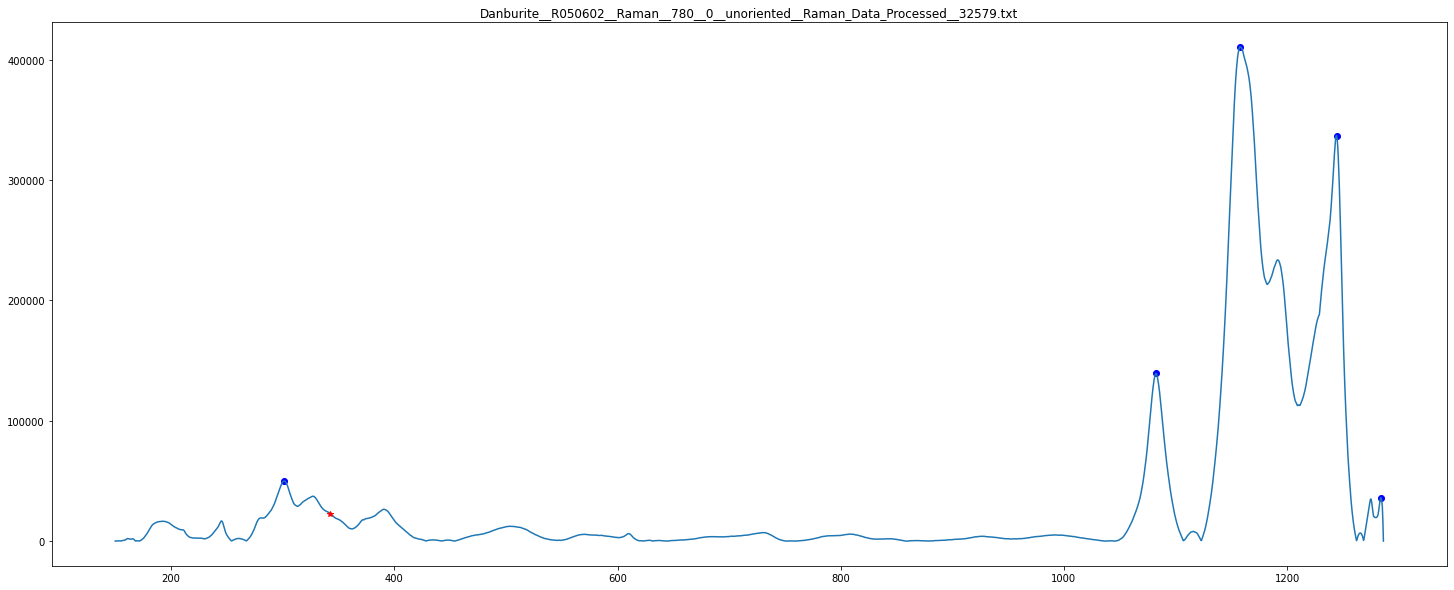

In [159]:
index = 51
tmp_idx = 400
plt.figure(figsize=(25, 10))
plt.plot(wavenumbers[index], spectras[index])
# plt.plot(wavenumbers[index][begin:end], spectras[index][begin:end])
plt.scatter(np.array(peaks[index])[:,0], np.array(peaks[index])[:,1] * np.max(spectras[index]), color='blue')
plt.plot(wavenumbers[index][tmp_idx], spectras[index][tmp_idx], 'r*')
plt.title(files_to_check[index])
plt.show()

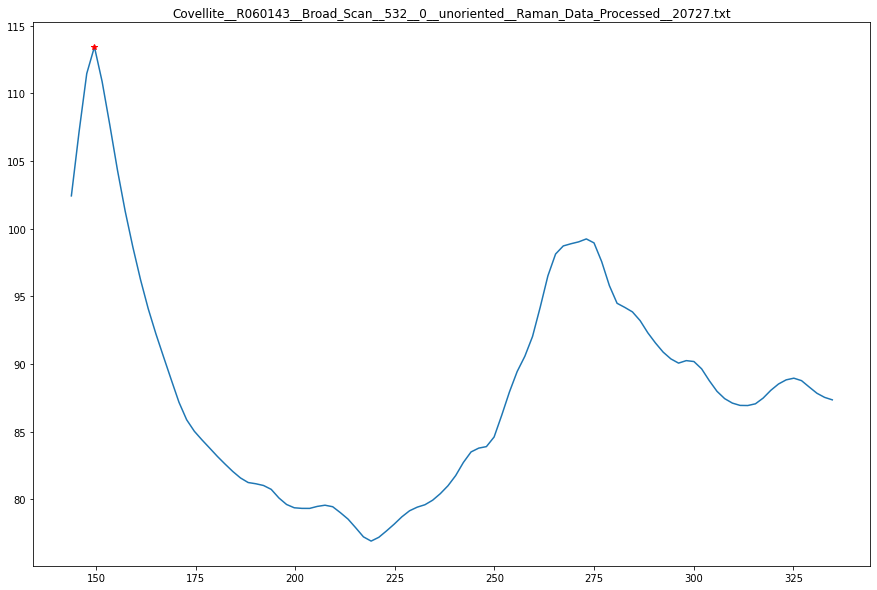

In [157]:
index = 49
tmp_idx = 3
start_idx = 0
end_idx = 100
plt.figure(figsize=(15, 10))
plt.plot(wavenumbers[index][start_idx:end_idx], spectras[index][start_idx:end_idx])
plt.plot(wavenumbers[index][tmp_idx], spectras[index][tmp_idx], 'r*')
# plt.plot(138.3965, 1862.331, 'r*')
plt.title(files_to_check[index])
plt.show()

In [156]:
index = 49
peaks[index][0][0]
np.where(wavenumbers[index] == 149.6292)
tmp_idx = 3
print("Wavenumber: {}".format(wavenumbers[index][tmp_idx]))
print("Intensity: {}".format(spectras[index][tmp_idx]))

Wavenumber: 149.6292
Intensity: 113.4295


In [160]:
labels = []

In [166]:
# index = 41
labels.append({1: (844.4171, 24914.75), 2: (4209.592, 36440.54), 3: (3571.269, 35805.47), 4: (4240.447, 34489.33), 5: (969.7675, 21147.46), 6: (940.8405, 20716.51), 
                7: (4464.149, 31665.37), 8: (4429.437, 31813.96), 9: (784.6346, 18906.03)})

# index = 42
labels.append({1: (482.7271, 1114.621), 2: (523.2249, 1045.879), 3: (781.6394, 788.5485), 4: (935.9167, 672.7941), 5: (681.3591, 800.8356), 6: (422.9446, 1052.707), 
                7: (550.2234, 924.3221)})

# index = 43
labels.append({1: (862.1342, 5367.389), 2: (831.2787, 4535.211), 3: (846.2243, 3556.652), 4: (784.9955, 2444.69), 5: (608.0587, 928.7065), 6: (808.6192, 882.7186), 
                7: (977.8422, 148.8295), 8: (586.8455, 335.7901), 9: (933.0053, 244.1711), 10: (914.2028, 112.1284)})

# index = 44
labels.append({1: (406.174, 40913.7), 2: (2953.678, 51328.96), 3: (485.241, 28617.02), 4: (2953.678, 51328.96), 5: (143.902, 27244.24), 6: (614.448, 13029.18),
              7: (1453.331, 16266.09), 8: (791.867, 11787.95), 9: (3001.89, 31360.13), 10: (2845.684, 23559.54), 11: (253.825, 15410.15), 12: (1729.102, 16256.85)})

# index = 45
labels.append({1: (910.9142, 4053.496), 2: (349.7304, 4586.09), 3: (453.8676, 3850.818), 4: (571.5041, 3609.972), 5: (257.164, 3468.596), 6: (270.6633, 3433.757),
              7: (1092.19, 1299.343), 8: (1285.037, 1365.841), 9: (1377.603, 1223.387), 10: (984.1959, 1540.284), 11: (170.383, 1549.502), 12: (602.3596, 2338.273),
              13: (1657.231, 1283.338), 14: (1564.664, 1200.153)})
               
# index = 46
labels.append({1: (864.4914, 1214.259), 2: (1591.523, 1256.697), 3: (285.9514, 800.3677)})
               
# index = 47
labels.append({1: (3597.869, 15370.01), 2: (560.5333, 2970.59), 3: (577.8895, 2959.326), 4: (672.3844, 2855.82), 5: (975.1537, 3847.477), 6: (1187.285, 4431.185),
              7: (1387.846, 5084.511)})
               
# index = 49
labels.append({1: (477.4686, 455.2916), 2: (149.6292, 113.4295), 3: (273.0511, 99.24055), 4: (928.7298, 111.826)})

In [ ]:
# index = 31 - 40

# index = 31
labels.append({1: (973.9041, 22607.7), 2: (645.1008, 14741.71), 3: (314.8511, 10802.12), 4: (1038.99, 6302.094), 5: (514.4472, 2328.385), 6: (243.0157, 2072.354), 
            7: (394.4003, 2564.863), 8: (153.8242, 2623.743), 9: (138.3965, 1862.331), 10: (996.0814, 4075.527), 11: (576.1581, 1302.662), 12: (717.4182, 824.145),  13:(460.4502, 427.6848)})

# index = 32
labels.append({1: (1085.735, 12627.27), 2: (279.6358, 2493.682), 3: (712.0944, 1409.423), 4: (154.2855, 794.4526), 5: (1014.864, 273.0842)})

# index = 33
labels.append({1: (242.4624, 2449.782), 2: (286.3349, 1003.515), 3: (634.4229, 316.4645), 4: (592.4788, 301.3776), 5: (476.2888, 212.0727), 6: (489.788, 120.7352),
             7: (695.1696, 38.99556)})

# index = 34
labels.append({1: (3499.517, 51506.58), 2: (2936.405, 51417.58), 3: (934.6563, 32511.82), 4: (1007.938, 32632.38), 5: (431.3265, 19569.69), 6: (629.9586, 22144.01),
                 7: (574.033, 21474.76), 8: (1461.128, 29242.62), 9: (1090.862, 25039.9)})

# index = 35
labels.append({1: (1000.4, 11396.18), 2: (454.6441, 1857.322), 3: (1157.088, 1034.03), 4: (638.8127, 691.9186), 5: (656.651, 572.6276), 
                6: (619.528, 514.3992), 7: (460.4295, 1588.879)})

# index = 36
labels.append({1: (508.324, 1350.626), 2: (988.5123, 589.6487), 3: (249.9095, 449.0841), 4: (168.9138, 472.4133), 5: (357.9036, 324.9977), 6: (685.743, 366.538), 
                7: (753.2393, 371.8107), 8: (305.835, 304.481), 9: (1056.009, 424.6125), 10: (728.1693, 358.3673)})

# index = 37
labels.append({1: (1063.335, 34454.83), 2: (1481.813, 29318.01), 3: (1373.818, 27597.74), 4: (845.4186, 16324.59), 5: (687.2843, 14297.67), 6: (147.3136, 13440.54), 
                7: (222.5238, 10294.52)})

# index = 38
labels.append({1: (479.069, 238399.8), 2: (334.676, 23042.88), 3: (1095.415, 25483.79), 4: (1031.5, 14632.72), 5: (794.268, 9359.719)})

# index = 39
labels.append({1: (291.4432, 24.49878), 2: (356.0468, 2.818775), 3: (324.2271, 1.627902), 4: (356.0468, 2.818775)})

# index = 40
labels.append({1: (601.342, 1678.743), 2: (601.342, 1678.743), 3: (3478.615, 1189.657), 4: (884.8267, 620.3753), 5: (1453.724, 351.8175), 6: (3006.14, 719.1489), 
                7: (2846.077, 427.5487), 8: (965.8223, 381.6835), 9: (1731.424, 289.0974), 10: (740.1917, 289.5102), 11: (815.4019, 395.4578), 
                12: (287.002, 265.4959)})

In [168]:
filename = "peaks_labeled_41-50.pkl"
open_file = open(filename, "wb")
pickle.dump(labels, open_file)
open_file.close()

In [167]:
labels

[{1: (844.4171, 24914.75),
  2: (4209.592, 36440.54),
  3: (3571.269, 35805.47),
  4: (4240.447, 34489.33),
  5: (969.7675, 21147.46),
  6: (940.8405, 20716.51),
  7: (4464.149, 31665.37),
  8: (4429.437, 31813.96),
  9: (784.6346, 18906.03)},
 {1: (482.7271, 1114.621),
  2: (523.2249, 1045.879),
  3: (781.6394, 788.5485),
  4: (935.9167, 672.7941),
  5: (681.3591, 800.8356),
  6: (422.9446, 1052.707),
  7: (550.2234, 924.3221)},
 {1: (862.1342, 5367.389),
  2: (831.2787, 4535.211),
  3: (846.2243, 3556.652),
  4: (784.9955, 2444.69),
  5: (608.0587, 928.7065),
  6: (808.6192, 882.7186),
  7: (977.8422, 148.8295),
  8: (586.8455, 335.7901),
  9: (933.0053, 244.1711),
  10: (914.2028, 112.1284)},
 {1: (406.174, 40913.7),
  2: (2953.678, 51328.96),
  3: (485.241, 28617.02),
  4: (2953.678, 51328.96),
  5: (143.902, 27244.24),
  6: (614.448, 13029.18),
  7: (1453.331, 16266.09),
  8: (791.867, 11787.95),
  9: (3001.89, 31360.13),
  10: (2845.684, 23559.54),
  11: (253.825, 15410.15),
  12

In [ ]:
labels = []

In [ ]:
peaks[]

In [ ]:
tmp_idx = 951
print(wavenumbers[index][tmp_idx])
print(spectras[index][tmp_idx])

In [ ]:
tmp_wavenumber

In [ ]:
path = 'RRUFF/raman/'
count = 0
analytes_peaks_wavenumber_dict = {}
for analyte in list(dataset_dict.items()):
  for filename in analyte[1]:
    tmp = pd.read_csv(path + filename, sep=',', comment='#', header=None)
    # wavenumber = np.array(tmp.iloc[:, 0], dtype=np.float64)
    spectra = np.array(tmp.iloc[:, 1], dtype=np.float64)
    maxtab, mintab = peakdet(spectra / np.max(spectra), 0.08)
    if analyte[0] not in analytes_peaks_dict:
      print('analyte not in dataset')
      print(analyte)
      # print(dataset_dict[analyte])
      if maxtab.ndim > 1 and mintab.ndim > 1:
        analytes_peaks_wavenumber_dict[analyte[0]] = [(filename, maxtab[:, 1] * np.max(spectra), mintab[:, 1] * np.max(spectra))]
    else:
      print('analyte in dataset')
      print(analyte)
      if maxtab.ndim > 1 and mintab.ndim > 1:
        analytes_peaks_wavenumber_dict[analyte[0]].append((filename, maxtab[:, 1] * np.max(spectra), mintab[:, 1] * np.max(spectra)))

In [ ]:
# filename = files[random.randint(0, len(files))]
filename = 'Zoisite__X060001__Raman__532__0__unoriented__Raman_Data_Processed__13166.txt'
check = pd.read_csv('RRUFF/raman/' + filename, sep=',', comment='#', header=None)
wavenumber = np.array(check.iloc[:, 0], dtype=np.float64)
spectra = np.array(check.iloc[:, 1], dtype=np.float64)
ref_quality = savgol_filter(spectra, 9, 3)
tmp_snr = 10 * math.log10(np.sum(np.abs(spectra) ** 2) / np.sum(np.abs(ref_quality - spectra) ** 2))
# snr.append(spectra / (ref_quality - spectra))
print(tmp_snr)
# print(sndr_mean / len(spectra))

maxtab, mintab = peakdet(spectra / np.max(spectra), 0.07, wavenumber)

import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))
plt.plot(wavenumber, spectra)
plt.plot(wavenumber, ref_quality)
plt.scatter(np.array(maxtab)[:,0], np.array(maxtab)[:,1] * np.max(spectra), color='blue')
# plt.scatter(np.array(mintab)[:,0], np.array(mintab)[:,1] * np.max(spectra), color='red')
plt.show()

In [ ]:
def find_peak_supp(int_idx, y_data, peak_importance_fun, discount=0.85):
    
    # int_idx
    #  -> left and right edges
    # y_data
    #  -> spectral data 
    # back_data
    #  -> spectral data 
    # discount=0.85
    #  -> how generous we are in getting the peaks to continue
    #  
    
    # SR: debug

    # int_idx=idx_lr_tmp
    
    # define the steppeness an the mse of the diff of the 
    
    # expand left and right until the steepness in         
    
    # TODO
    # checknig for teh boundaries "should" be unnecessary 
    
    res=len(y_data)
    
    l_pos_temp=int(np.max([int_idx[0],0]))
    r_pos_temp=int(np.min([int_idx[1],res-1]))
    
    # extend the peak until the decrease from the max importance you have seen in the window is discont*max
    # 
    max_impo = peak_importance_fun(y_data[range(int_idx[0],int_idx[1])])
    
    # expand the interval until is decreasing by a factor discount, discount account for the randomness in the error
    # the discount starts from the median of the vector
    
    expand_left = True
    expand_right = True
    
    while expand_left == True or expand_right == True:
        
        # check boundariens

        if l_pos_temp==0:
           expand_left=False
           
        if r_pos_temp==res-1:
            expand_right = False
            
        
        if expand_left == True:            
            impo_left = peak_importance_fun(y_data[range(l_pos_temp-1,r_pos_temp)])
                                            
            if impo_left < discount*max_impo:
               expand_left=False     
            else :
               l_pos_temp=l_pos_temp-1
               
        if expand_right == True:
            impo_rigth=peak_importance_fun(y_data[range(l_pos_temp,r_pos_temp+1)])
            
            if impo_rigth< discount*max_impo : 
               expand_left=False     
            else :
               r_pos_temp=r_pos_temp+1
            
        
        # update max importance
        # TODO we can do this better?
        tmp_impo = peak_importance_fun(y_data[range(l_pos_temp,r_pos_temp)])
        
        if tmp_impo > max_impo:
            max_impo=tmp_impo 
        
    return [l_pos_temp,r_pos_temp]


In [ ]:
with open('analytes_peaks_dict.json', 'w') as fp:
    json.dump(analytes_peaks_dict, fp)

In [ ]:
class RRUFFSpectraDataset(Dataset):
    def __init__(self, labels, spectra_dir, transform=None, target_transform=None):
        self.spectra_labels = json.load(labels)
        self.spectra_dir = spectra_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.spectra_labels)

    def __getitem__(self, idx):
        spectra_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label